# Segmentez des clients d'un site e-commerce
## Notebook 2 : Analyse exploratoire et premier feature ingineering
OpenClassrooms - Parcours Data Scientist - Projet 05  

## Sommaire  
**Préparation de l'environnement**  
* Environnement virtuel
* Import des modules
* Fonction

**Analyse exploratoire**
* Schéma relationnel   
* Analyses univariées

**Premier feature engineering**
 


# 1 Préparation de l'environnement

## 1.1 Environnement virtuel

In [1]:
# Vérification environnement virtuel
envs = !conda env list
print(f"Environnement virtuel : {[e for e in envs if '*' in e][0].split('*')[1].strip()}")

Environnement virtuel : C:\Users\chrab\anaconda3\envs\opc5


## 1.2 Import des modules

In [2]:
# Installation des librairies
!pip install ipython-sql --quiet
!pip install pandas --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet

In [3]:
# Import des modules
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

## 1.3 Fonctions

In [4]:
# Renvoit le résultat d'une requête SQL
def query_result(query: str, all_rows: bool=True):
    with sqlite3.connect('olist.db') as conn:
        cursor = conn.cursor()
        cursor.execute(query)
        if all_rows:
            result = cursor.fetchall()
        else:
            result = cursor.fetchone()
            if len(result) == 1:
                result = result[0]
    return result

In [5]:
# Renvoit le résultat d'une requête SQL sous forme de dataframe
def f_query_result(query: str):
    with sqlite3.connect('olist.db') as conn:
        df = pd.read_sql_query(query, conn)
    return df

In [6]:
# Description des champs d'une table (à base de requêtes SQL)
def describe_table(table_name: str, fields=None):
    # Préparation des colonnes du dataframe de descriptions
    df_names, df_types, df_unique_values, df_duplicates, df_missing_values, df_percentage_missing = [], [], [], [], [], []
    
    # Récupération de la liste des champs de la table
    pragma = query_result(f"PRAGMA table_info({table_name});")
    table_fields = [row[1] for row in pragma]

    # Constitution de la liste des champs à décrire
    if fields is None:
        fields = [field for field in table_fields if field != 'index']
    elif isinstance(fields, str):
        fields = [fields]
        
    # Récupération/calculs des informations descriptives
    total_rows = query_result(f"SELECT COUNT(*) FROM {table_name};", False)
    for field_index, field_name in enumerate(table_fields):
        if field_name in fields:
            field_type = pragma[field_index][2]
            unique_values = query_result(f"SELECT COUNT(DISTINCT {field_name}) FROM {table_name};", False)
            non_null_values = query_result(f"SELECT COUNT({field_name}) FROM {table_name};", False)
            duplicates = non_null_values - unique_values
            missing_values = total_rows - non_null_values
            percentage_missing = (missing_values / total_rows) * 100 if total_rows > 0 else 0
            percentage_missing = str(round(percentage_missing, 2)) + ' %'

            df_names.append(field_name)
            df_types.append(field_type)
            df_unique_values.append(unique_values)
            df_duplicates.append(duplicates)
            df_missing_values.append(missing_values)
            df_percentage_missing.append(percentage_missing)

    # Céation du dataframe de description
    df_infos = pd.DataFrame({
        'Colonne': df_names,
        'Type': df_types,
        'Valeurs uniques': df_unique_values,
        'Doublons': df_duplicates,
        'Valeurs manquantes': df_missing_values,
        '% valeurs manquantes': df_percentage_missing
    }).reset_index(drop=True)

    return df_infos

In [7]:
# Description des varaibles d'un dataframe
def get_dataframe_infos(df):
    '''
    Examine le dataframe (ou la series) 'df' fourni en paramètre et renvoit un dataframe 'df_infos' composé des variables :
    - 'Colonne' : nom des variables de df
    - 'Type' : type de la colonne
    - 'Valeurs uniques' : nombre de valeurs unique de la colonne
    - 'Valeurs manquantes' : nombre de valeurs manquantes de la colonne
    - '% valeurs manquantes' : pourcentage de valeurs manquantes de la colonne
    - 'Doublons' : nombre de valeurs non uniques (doublons) de la colonne
    '''
    if isinstance(df, pd.Series):
        df = df.to_frame()
    number_of_rows = df.shape[0]
    col_names = df.columns
    col_types = df.dtypes
    unique_values = df.nunique()
    missing_values = df.isnull().sum()
    non_missing_values = number_of_rows - missing_values
    duplicate_values = non_missing_values - unique_values

    df_infos = pd.DataFrame({
        'Colonne': col_names,
        'Type': col_types,
        'Valeurs uniques': unique_values,
        'Doublons': duplicate_values,
        'Valeurs manquantes': missing_values,
        '% valeurs manquantes': round((missing_values / number_of_rows) * 100, 2).astype(str) + " %"
    }).reset_index(drop=True)

    return df_infos

In [8]:
# Transforme les types des variables d'un dataframe
def transform_data_types(df, transformations):
    # Conversion en type string ou category si le nbre de valeurs uniques est faible
    if 'to_string' in transformations:
        for column in transformations['to_string']:
            if df[column].nunique() / len(df[column]) < 0.02:
                df[column] = df[column].astype('category')
            else:
                df[column] = df[column].astype(str)
    
    # Conversion en dates
    if 'to_date' in transformations:
        for column in transformations['to_date']:
            df[column] = pd.to_datetime(df[column], errors='coerce')
    
    # Conversion en entier avec gestion NaN
    if 'to_integer' in transformations:
        for col in transformations['to_integer']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

    # Conversion en flottants
    if 'to_float' in transformations:
        for col in transformations['to_float']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)
    
    # Transformation en dates avec gestion NaT
    if 'to_date' in transformations:
        for column in transformations['to_date']:
            df[column] = pd.to_datetime(df[column], errors='coerce').dt.round('s')
    
    return df

In [61]:
# Affiche l'histogramme et le boxplot d'une feature
def plot_distribution(dataframe, feature, x_label, y_label, x_tick_angle=None):
    fig, axs = plt.subplots(2, 1, figsize=(6, 4.5), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    plt.subplots_adjust(hspace=0.05)  # Ajuste l'espace entre les graphiques
    
    # Histogramme
    sns.histplot(dataframe[feature], bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f'Distribution {feature}', pad=10)
    axs[0].set_xlabel('')  # Supprime le label de l'axe x pour l'histogramme
    axs[0].set_ylabel(y_label)
    axs[0].grid(linewidth=0.25)
    
    # Boxplot
    sns.boxplot(x=dataframe[feature], ax=axs[1])
    axs[1].set_xlabel(x_label)
    axs[1].set_yticks([])  # Supprime les ticks de l'axe y pour le boxplot

    if x_tick_angle is not None:
        for axis in axs:
            for label in axis.get_xticklabels():
                label.set_rotation(x_tick_angle)

    plt.show()

# 2 Analyse exploratoire

## 2.1 Schéma relationnel

![shema relationnel](schema_relationnel_olist.png "Shéma relationnel BDD olist")

L'objectif est de réaliser une **segmentation des clients**.  
Je vais donc porter une attention particulière sur les champs me permettant de calculer des scores par client :  
* **Récence** : date de la dernière commande => `orders.order_approved_at` ?  
* **Fréquence** : nombre total de commandes => `customers.customer_id`, `orders.order_id` ou `orders.customer_id` ?  
* **Montant** : valeur totale des achats => `order_items.price` (+ `order_items.freight` ?), `order_pymts.payment_value` ?  
* **Panier moyen** : valeur moyenne d'un achat => Montant total / nombre de commandes  
* **Score de satisfaction** : notes de satisfaction => `order_reviews.review_score` (comment compléter les manquants : KNN ?)
* **Motif d'insatisfation** ??? Si pertinent, comment obtenir cette info ? 
* **Délai de livraison** : `orders.order_delivered_customer_date` - `orders.order_purchase_timestamp` ? `orders.order_delivered_customer_date` - `orders.order_approved_at` ?
* **Retard de livraison** : `orders.order_delivered_customer_date` - `orders.estimated_delivery_date`
* **Situation géographique du client** ???
* **Distance par rapport au vendeur** ??? Si pertinent comment gérer les commandes regroupant plusieurs vendeurs ? La moyenne des distances serait pertinente ? 

## 2.2 Analyses univariées

* Utilisation des fonctions :
   * `describe_table('nom_table')` : récupère et calcule le nom des champs, leur type, le nombre de valeurs uniques, de doublons, de valeurs manquantes directement sur la table, en SQL, puis renvoie un dataframe
   * `f_query_result('query')` : exécute une requête SQL et renvoie un dataframe
   * `get_df_infos(dataframe)` : renvoie un dataframe avec les mêmes informations que `describe_table()`, mais calculées en python à partir d'un dataframe
* Toutes les tables de la BDD contiennent un champ `index` qui sera supprimé à chaque récupération sous forme de dataframe, pour ne pas faire double-emploi

### 2.2.1 Table `orders`

In [10]:
# Récupération de tout le contenu de la table dans un dataframe
df_orders = f_query_result("SELECT * FROM orders;").drop('index', axis=1)

In [11]:
# Affichage de quelques lignes
display(df_orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [12]:
# Description des champs de la table
display(describe_table('orders'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,99441,0,0,0.0 %
1,customer_id,TEXT,99441,0,0,0.0 %
2,order_status,TEXT,8,99433,0,0.0 %
3,order_purchase_timestamp,TEXT,98875,566,0,0.0 %
4,order_approved_at,TEXT,90733,8548,160,0.16 %
5,order_delivered_carrier_date,TEXT,81018,16640,1783,1.79 %
6,order_delivered_customer_date,TEXT,95664,812,2965,2.98 %
7,order_estimated_delivery_date,TEXT,459,98982,0,0.0 %


In [13]:
# Description des variables du dataframe
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,object,8,99433,0,0.0 %
3,order_purchase_timestamp,object,98875,566,0,0.0 %
4,order_approved_at,object,90733,8548,160,0.16 %
5,order_delivered_carrier_date,object,81018,16640,1783,1.79 %
6,order_delivered_customer_date,object,95664,812,2965,2.98 %
7,order_estimated_delivery_date,object,459,98982,0,0.0 %


* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Toutes les colonnes de la table sont de type `TEXT`, et transformées en type `OBJECT` via l'import en dataframe
* Les variables doivent être converties dans les bons types

In [14]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'customer_id', 'order_status'],
    'to_date': ['order_purchase_timestamp',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
}

# Conversions
df_orders = transform_data_types(df_orders, to_transform)

* Verification des transformations

In [15]:
# Description des variables du dataframe
display(get_dataframe_infos(df_orders))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,99441,0,0,0.0 %
1,customer_id,object,99441,0,0,0.0 %
2,order_status,category,8,99433,0,0.0 %
3,order_purchase_timestamp,datetime64[ns],98875,566,0,0.0 %
4,order_approved_at,datetime64[ns],90733,8548,160,0.16 %
5,order_delivered_carrier_date,datetime64[ns],81018,16640,1783,1.79 %
6,order_delivered_customer_date,datetime64[ns],95664,812,2965,2.98 %
7,order_estimated_delivery_date,datetime64[ns],459,98982,0,0.0 %


In [16]:
# Principales mesures statistiques
df_orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99281,97658,96476,99441
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


#### 2.2.1.1 `order_status`

* Valeurs uniques

In [17]:
df_order_status = df_orders['order_status'].value_counts().to_frame()
no_orders = df_orders.shape[0]
df_order_status['%'] = round((df_order_status['count'] / no_orders) * 100, 2).astype(str) + ' %'
display(df_order_status)

,count,%
order_status,,
delivered,96478,97.02 %
shipped,1107,1.11 %
canceled,625,0.63 %
unavailable,609,0.61 %
invoiced,314,0.32 %
processing,301,0.3 %
created,5,0.01 %
approved,2,0.0 %


* La très grande majorité des commandes ont le statut 'delivered' ($97.02 \%$)  
* Les commandes avec un statut différent pourront être supprimées :
   * Représentant moins de $3 \%$ des commandes, sans elles les résultats ne seront pas impactés
   * N'étant pas livrées, ces commandes n'auront pas de review, on ne pourra pas calculer le délai de livraison...

In [18]:
# Suppression des commandes non livrées
mask = df_orders['order_status'] != 'delivered'
df_orders = df_orders.loc[~mask]

* La variable `order_status` n'a plus d'intérêt

In [19]:
# Suppression de la variable 'order_status'
df_orders = df_orders.drop('order_status', axis=1)

#### 2.2.1.2 `order_purchase_timestamp`, `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date`, `order_estimated_delivery_date`

In [20]:
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

In [21]:
display(get_dataframe_infos(df_orders[date_fields]))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_purchase_timestamp,datetime64[ns],95956,522,0,0.0 %
1,order_approved_at,datetime64[ns],88274,8190,14,0.01 %
2,order_delivered_carrier_date,datetime64[ns],80106,16370,2,0.0 %
3,order_delivered_customer_date,datetime64[ns],95658,812,8,0.01 %
4,order_estimated_delivery_date,datetime64[ns],445,96033,0,0.0 %


* Quelles sont les commandes sans date d'approbation ?

In [22]:
wo_approbation_mask = df_orders['order_approved_at'].isna()
display(df_orders.loc[wo_approbation_mask])

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


In [23]:
# Date des première et dernière commandes sans dates d'approbation
wo_approbation_start_date = df_orders.loc[wo_approbation_mask, 'order_purchase_timestamp'].min()
wo_approbation_end_date = df_orders.loc[wo_approbation_mask, 'order_purchase_timestamp'].max()
display(wo_approbation_start_date)
display(wo_approbation_end_date)

Timestamp('2017-01-19 12:48:08')

Timestamp('2017-02-19 01:28:47')

* Il semblerait qu'il y ait eu un souci sur une période d'un mois, entre les 19 janvier et 19 février 2017
* Stratégie pour remplacer ces valeurs manquantes :
   * Calculer le délai moyen entre la date de validation du paiement `order_approved_at` et la date de dépôt au livreur `order_delivered_carrier_at`
   * Si ce délai est relativement constant sur une courte période avant et après la période problématique, l'appliquer en s'assurant que la date calculée ne soit pas antérieure à la date d'achat `order_approved_at`

In [24]:
# Affichage de toutes les commandes de la période 

In [25]:
period_mask = (df_orders['order_purchase_timestamp'] >= wo_approbation_start_date) & \
              (df_orders['order_purchase_timestamp'] <= wo_approbation_end_date)
df_orders.loc[period_mask]

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06
106,a6cd683d4bd3b9b1f0aa37b27f8116d3,48f239e15744ed5e7ffbafc6bb6e882b,2017-01-28 23:45:53,2017-01-29 01:31:48,2017-02-01 14:25:06,2017-02-10 17:30:19,2017-03-10
251,bb4f0c21ae6014e40ef007ff6fbcbeb9,94f7f1cb719dd707fd437e918d282537,2017-02-12 18:48:56,2017-02-12 19:02:52,2017-02-16 14:42:05,2017-03-01 14:09:10,2017-03-16
258,51fc12a7908ea200b269a6ecfb3e7740,abbfa19a38ba17ff02883ba523a9d42f,2017-02-08 18:00:36,2017-02-10 02:55:28,2017-02-15 12:37:51,2017-02-20 18:14:01,2017-03-17
303,bd2623f3663c5daa3f89e6b527fd49da,b7b15ab12fa50616eee696a22f098e07,2017-01-21 17:08:01,2017-01-21 17:22:49,2017-01-24 07:47:47,2017-01-27 18:12:13,2017-03-02
...,...,...,...,...,...,...,...
99156,d84b3fdfbb838b26178304662ff635e1,aa90812c60112bac39cefe1f2ed45d84,2017-02-05 18:54:57,2017-02-05 19:05:16,2017-02-07 07:28:05,2017-02-10 12:03:38,2017-03-06
99180,469f0b908881368c45917f1bed8240ce,59e4d7310198da197337571749b47ff2,2017-01-24 21:35:25,2017-01-25 16:30:14,2017-01-26 06:32:47,2017-02-08 08:14:01,2017-03-23
99190,7a9f31f6c0e36f4e6fb8d27c49c18fd6,4db09730e85cacf07aa9c7ce98ee2a16,2017-02-18 12:27:48,2017-02-18 13:05:49,2017-02-20 12:32:42,2017-03-16 09:28:00,2017-03-31
99329,9058bc799c3791077efb3aaa8e0d5e02,3fb83e207757e8f15ff70d937c86929b,2017-01-24 09:24:11,2017-01-25 02:45:13,2017-01-25 13:20:38,2017-01-30 09:39:02,2017-03-01


* 1720 commandes de cette même période ne sont pas concernées par le problème  
* Le délai moyen sera calculé sur cette période

In [26]:
# Dates de début et de fin
start_date = df_orders.loc[mask, 'order_purchase_timestamp'].min()
end_date = df_orders.loc[mask, 'order_purchase_timestamp'].max()

In [27]:
# Création d'une colonne contenant le délai en heures entre la date d'approbation et la date de dépôt au livreur
df_orders['approval_delay'] = (df_orders['order_delivered_carrier_date'] - df_orders['order_approved_at']).dt.total_seconds() / 3600

# Calculer le délai moyen en heures
average_delay_hours = df_orders.loc[period_mask, 'approval_delay'].mean()

print(f"Le délai moyen de mise en livraison est de {average_delay_hours} heures.")

Le délai moyen de mise en livraison est de 71.82518040901394 heures.


In [28]:
# Affichage des statistiques
df_orders.loc[period_mask, 'approval_delay'].to_frame().describe()

,approval_delay
count,1706.000000
mean,71.825180
std,106.525119
min,-162.771389
25%,17.254236
50%,41.064028
75%,83.612847
max,1317.925000


* Avec délai minimum de **-163 heures**, un maximum de **1 318 heures** et un écart-type de **107 heures**, prendre une valeur moyenne n'aurait aucun sens  
*(Y-a-t-il des commandes qui sont mises en livraison avant validation du paiement ?)*

* Le délai entre la validation du paiement et la mise en livraison est-il plus stable ?

In [29]:
# Création d'une colonne contenant le délai en heures entre la date d'achat et la date de validation du paiement
df_orders['shipping_preparation_delay'] = (df_orders['order_approved_at'] - df_orders['order_purchase_timestamp']).dt.total_seconds() / 3600

# Calculer le délai moyen en heures
average_delay_hours = df_orders.loc[period_mask, 'shipping_preparation_delay'].mean()

print(f"Le délai moyen de validation du paiement est de {average_delay_hours} heures.")

Le délai moyen de validation du paiement est de 9.377638888888889 heures.


In [30]:
# Affichage des statistiques
df_orders.loc[period_mask, 'shipping_preparation_delay'].to_frame().describe()

,shipping_preparation_delay
count,1706.000000
mean,9.377639
std,19.674242
min,0.095000
25%,0.185556
50%,0.240556
75%,12.519167
max,267.106389


* Avec délai minimum de **quelques minutes**, un maximum de **267 heures** et un écart-type de **21 heures**, prendre une valeur moyenne n'aurait pas plus de sens

* Abandon de la tentative de correction des valeurs manquantes, et suppression des 14 commandes concernées (0.01 % du nombre total de commandes)

In [31]:
# Suppression des commandes sans `order_approved_date`
df_orders = df_orders.loc[~wo_approbation_mask]

In [32]:
# Mise à jour des infos
display(get_dataframe_infos(df_orders[date_fields]))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_purchase_timestamp,datetime64[ns],95942,522,0,0.0 %
1,order_approved_at,datetime64[ns],88274,8190,0,0.0 %
2,order_delivered_carrier_date,datetime64[ns],80094,16368,2,0.0 %
3,order_delivered_customer_date,datetime64[ns],95644,812,8,0.01 %
4,order_estimated_delivery_date,datetime64[ns],445,96019,0,0.0 %


* Suppression des 2 commandes sans date de mise en livraison  
* Suppression des 8 commandes non encore livrées

In [33]:
# Suppression
mask = (df_orders['order_delivered_carrier_date'].isna()) | (df_orders['order_delivered_customer_date'].isna())
df_orders = df_orders.loc[~mask]

* Graphiques des distributions

In [34]:
date_fields = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
# date_fields = list(df_orders.columns)

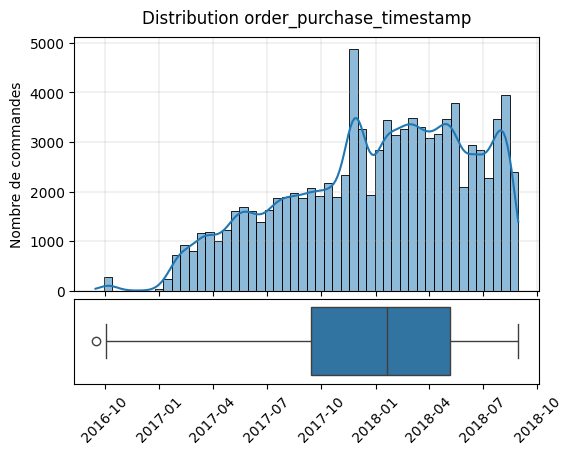

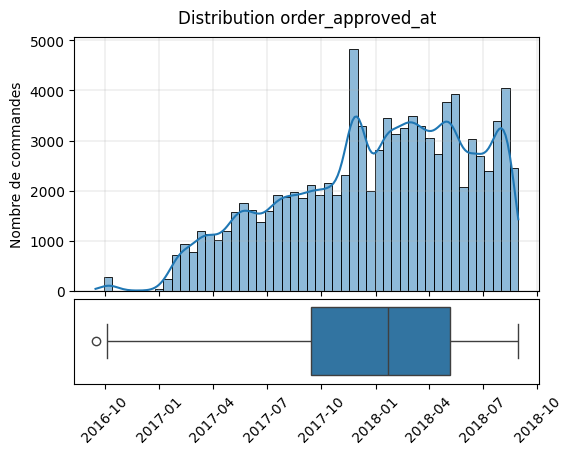

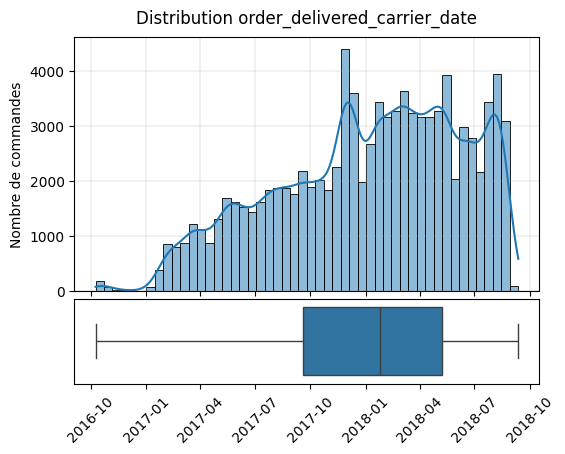

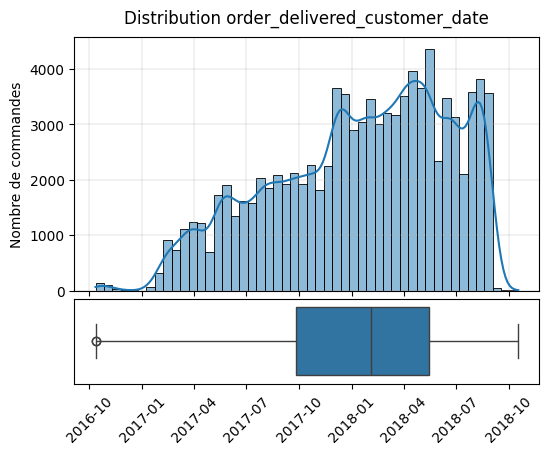

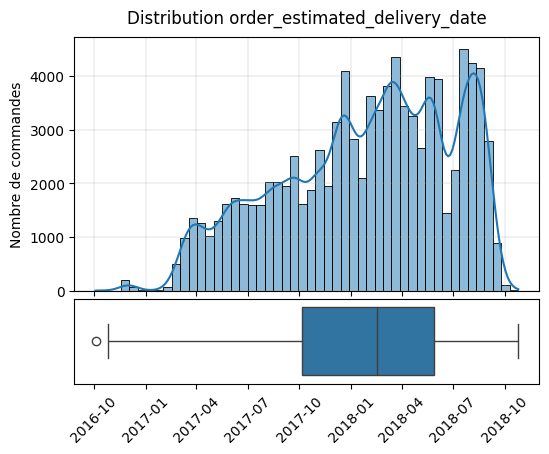

In [62]:
for feature in date_fields:
    plot_distribution(df_orders, feature, 'Nombre de commandes', '', x_tick_angle=45)
    print()

* Les répartitions des distributions se ressemblent fortement, il est probable que ces variables soient fortement corrélées entre elles.
* Ce serait logique puisque ces dates correspondent à des événement qui s'enchaînent (achat -> validation du paiement -> mise en livraison...)

### 2.2.2 Table `order_items`

In [36]:
# Récupération de tout le contenu de la table dans un dataframe
df_order_items = f_query_result("SELECT * FROM order_items;").drop('index', axis=1)

In [37]:
# Affichage de quelques lignes
display(df_order_items)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [38]:
# Description des champs de la table
display(describe_table('order_items'))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,TEXT,98666,13984,0,0.0 %
1,order_item_id,BIGINT,21,112629,0,0.0 %
2,product_id,TEXT,32951,79699,0,0.0 %
3,seller_id,TEXT,3095,109555,0,0.0 %
4,shipping_limit_date,TEXT,93318,19332,0,0.0 %
5,price,FLOAT,5968,106682,0,0.0 %
6,freight_value,FLOAT,6999,105651,0,0.0 %


In [39]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,98666,13984,0,0.0 %
1,order_item_id,int64,21,112629,0,0.0 %
2,product_id,object,32951,79699,0,0.0 %
3,seller_id,object,3095,109555,0,0.0 %
4,shipping_limit_date,object,93318,19332,0,0.0 %
5,price,float64,5968,106682,0,0.0 %
6,freight_value,float64,6999,105651,0,0.0 %


* Hormis les types, les informations relevées sont strictement identiques👍🏼
* Aucune valeur n'est manquante
* Les variables `order_id`, `product_id`, `seller_id` et `shipping_limit_date` doivent être converties dans les bons types
* Les lignes de commandes correspondant aux commandes supprimées dans la table `orders`, doivent être aussi supprimées

In [40]:
# Dictionnaire de conversion
to_transform = {
    'to_string': ['order_id', 'product_id', 'seller_id'],
    'to_date': ['shipping_limit_date']
}

# Conversions
df_order_items = transform_data_types(df_order_items, to_transform)

* Vérification des transformations

In [41]:
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,98666,13984,0,0.0 %
1,order_item_id,int64,21,112629,0,0.0 %
2,product_id,object,32951,79699,0,0.0 %
3,seller_id,object,3095,109555,0,0.0 %
4,shipping_limit_date,datetime64[ns],93318,19332,0,0.0 %
5,price,float64,5968,106682,0,0.0 %
6,freight_value,float64,6999,105651,0,0.0 %


* Suppression des lignes de commandes sans commande

In [50]:
# Récupération des 'order_id' de la table 'orders'
valid_order_ids = df_orders['order_id'].unique()

In [52]:
# Filtre sur les 'order_id' valides
valid_orders_mask = df_order_items['order_id'].isin(valid_order_ids)

In [53]:
# Suppression des lignes de 'df_order_items' ne correspondant pas à une commande valide dans 'df_orders'
df_order_items = df_order_items.loc[valid_orders_mask]

* Mise à jour de la descriptions des variables

In [54]:
# Description des variables du dataframe
display(get_dataframe_infos(df_order_items))

,Colonne,Type,Valeurs uniques,Doublons,Valeurs manquantes,% valeurs manquantes
0,order_id,object,96455,13718,0,0.0 %
1,order_item_id,int64,21,110152,0,0.0 %
2,product_id,object,32210,77963,0,0.0 %
3,seller_id,object,2970,107203,0,0.0 %
4,shipping_limit_date,datetime64[ns],91321,18852,0,0.0 %
5,price,float64,5859,104314,0,0.0 %
6,freight_value,float64,6924,103249,0,0.0 %


In [56]:
# Principales mesures statistiques
df_order_items.describe()

,order_item_id,shipping_limit_date,price,freight_value
count,110173.000000,110173,110173.000000,110173.000000
mean,1.198216,2018-01-08 18:12:57.306299904,119.978575,19.949051
min,1.000000,2016-09-19 23:11:33,0.850000,0.000000
25%,1.000000,2017-09-21 15:10:11,39.900000,13.080000
50%,1.000000,2018-01-26 20:37:29,74.900000,16.260000
75%,1.000000,2018-05-10 20:30:37,134.170000,21.150000
max,21.000000,2020-04-09 22:35:08,6735.000000,409.680000
std,0.706743,NaN,182.314081,15.699528


#### 2.2.2.1 `order_item_id`

Cette variable représente le nombre de produits identiques dans la même commande

* Valeurs uniques

In [59]:
df_order_item_id = df_order_items['order_item_id'].value_counts().to_frame()
no_order_items = df_order_items.shape[0]
df_order_item_id['%'] = round((df_order_item_id['count'] / no_order_items) * 100, 3).astype(str) + ' %'
display(df_order_item_id)

,count,%
order_item_id,,
1,96455,87.549 %
2,9634,8.744 %
3,2243,2.036 %
4,937,0.85 %
5,442,0.401 %
6,249,0.226 %
7,58,0.053 %
8,36,0.033 %
9,28,0.025 %


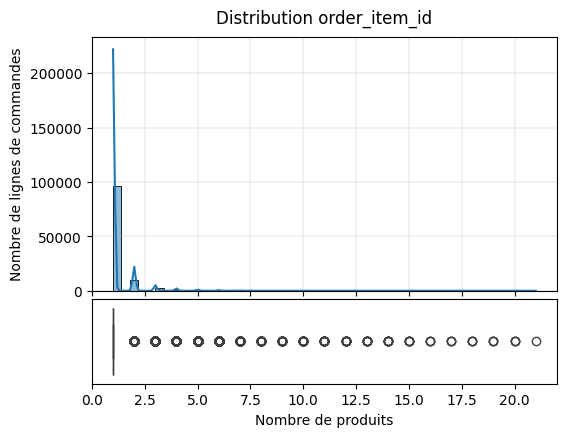

In [64]:
# Affichage de la distribution
plot_distribution(df_order_items, 'order_item_id', 'Nombre de lignes de commandes', 'Nombre de produits')